# Capstone Milestone 1: Exploratory Data Analysis

**Goal:** To analyze the call center dataset to understand key demand patterns and identify drivers for forecasting. This analysis will focus on the two primary metrics required for the project: `Incoming Calls` and `Talk Duration`.

**Methodology:**
1.  **Setup & Cleaning:** Load data, convert time fields, and engineer date-based features.
2.  **Primary Metric Analysis:** Investigate the `Incoming Calls` for major trends and seasonality.
3.  **Hypothesis-Driven Analysis:** Test specific hypotheses related to business drivers (e.g., tax season, service level impact).
4.  **Secondary Metric Analysis:** Analyze `Talk Duration` patterns.
5.  **Time Series Diagnostics:** Use statistical tools (ACF/PACF, Decomposition) to prepare for modeling.
6.  **Summary:** Conclude with key insights, data limitations, and a plan for feature engineering and modeling.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


def time_to_seconds(time_str):
    if isinstance(time_str, str):
        parts = list(map(int, time_str.split(":")))
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    return np.nan


sns.set_style("whitegrid")

In [3]:
FILE_PATH = "../data/raw/call-center-data-v2-daily.csv"

try:
    df = pd.read_csv(FILE_PATH, parse_dates=["Date"])
    print(f"Successfully loaded and parsed data from '{FILE_PATH}'")
except FileNotFoundError:
    print(
        f"Error: The file was not found at '{FILE_PATH}'. Please validate the path."
    )
    df = None

if df is not None:
    time_cols = [
        "Answer Speed (AVG)",
        "Talk Duration (AVG)",
        "Waiting Time (AVG)",
    ]
    for col in time_cols:
        new_col_name = col.replace("(AVG)", "(seconds)").strip()
        df[new_col_name] = df[col].apply(time_to_seconds)

    df["day_name"] = df["Date"].dt.day_name()
    df["month"] = df["Date"].dt.month
    df["year"] = df["Date"].dt.year
    df["is_weekend"] = df["day_name"].isin(["Saturday", "Sunday"])
    df["is_tax_season"] = df["month"].isin([3, 4])

    print("\n--- DataFrame Information ---")
    df.info()

    print("\n--- DataFrame Head ---")
    display(df.head())

Successfully loaded and parsed data from '../data/raw/call-center-data-v2-daily.csv'

--- DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     1247 non-null   datetime64[ns]
 1   Incoming Calls           1247 non-null   int64         
 2   Answered Calls           1247 non-null   int64         
 3   Abandoned Calls          1247 non-null   int64         
 4   Answer Speed (AVG)       1247 non-null   object        
 5   Talk Duration (AVG)      1247 non-null   object        
 6   Waiting Time (AVG)       1247 non-null   object        
 7   Answer Speed (seconds)   1247 non-null   int64         
 8   Talk Duration (seconds)  1247 non-null   int64         
 9   Waiting Time (seconds)   1247 non-null   int64         
 10  day_name                 1247 non-null  

,Date,Incoming Calls,Answered Calls,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Answer Speed (seconds),Talk Duration (seconds),Waiting Time (seconds),day_name,month,year,is_weekend,is_tax_season
0,2022-01-01,157,145,12,0:00:15,0:02:29,0:03:12,15,149,192,Saturday,1,2022,True,False
1,2022-01-02,37,37,0,0:00:03,0:02:06,0:00:35,3,126,35,Sunday,1,2022,True,False
2,2022-01-03,317,304,13,0:00:18,0:01:35,0:02:37,18,95,157,Monday,1,2022,False,False
3,2022-01-04,253,244,9,0:00:13,0:01:50,0:02:02,13,110,122,Tuesday,1,2022,False,False
4,2022-01-05,214,205,9,0:00:10,0:02:10,0:03:22,10,130,202,Wednesday,1,2022,False,False


## 1. Analysis of Primary Metric: `Incoming Calls`

First, let's understand the overall behavior of the primary demand driver: Incoming Calls.

--- Time Series of Incoming Calls ---


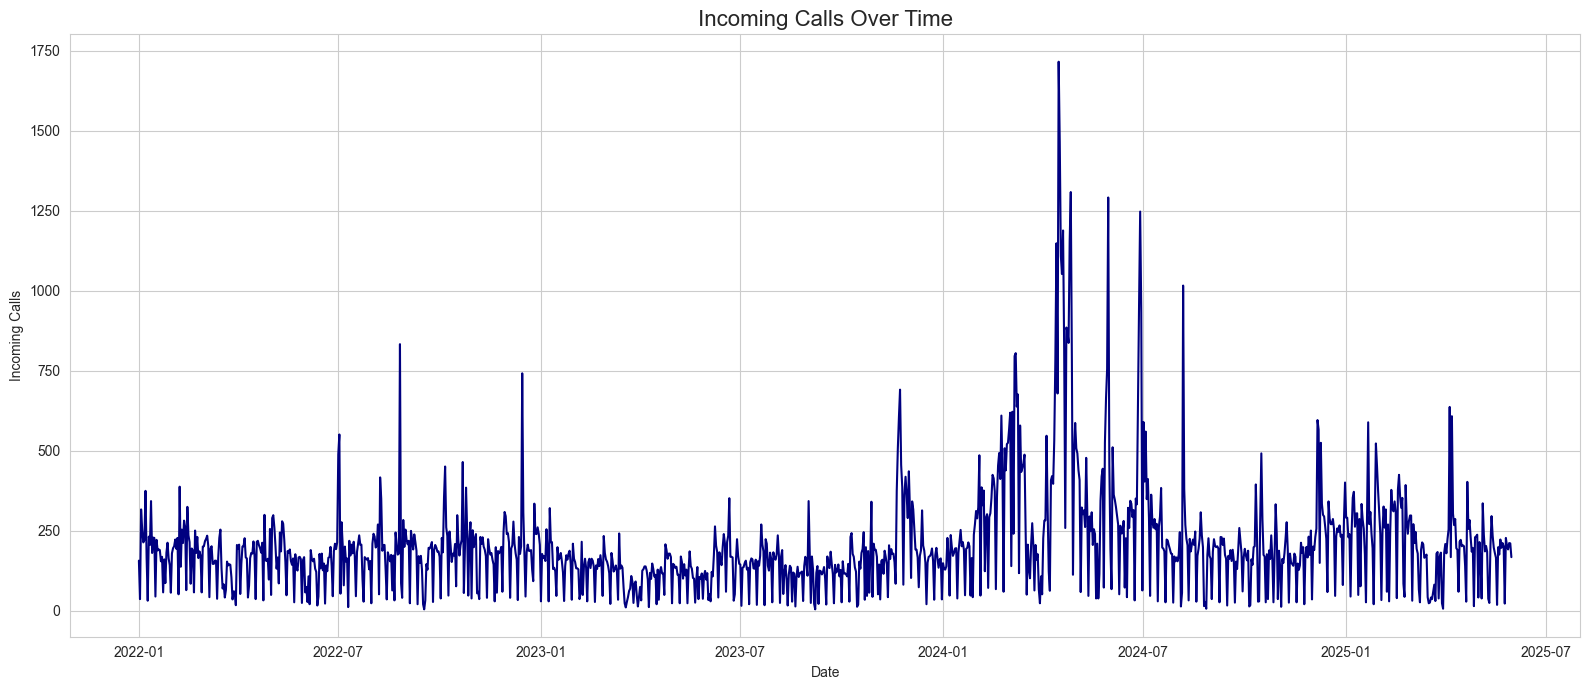

In [4]:
if df is not None:
    print("--- Time Series of Incoming Calls ---")
    plt.figure(figsize=(16, 7))
    sns.lineplot(data=df, x="Date", y="Incoming Calls", color="navy")
    plt.title("Incoming Calls Over Time", fontsize=16)
    plt.tight_layout()
    plt.show()

This time series plot illustrates the daily volume of incoming calls from January 2022 through May 2025. The data is characterized by a strong and persistent **seasonality**, evident in the regular cycle of high-volume weekdays and low-volume weekends. While a consistent long-term trend is not apparent, the series exhibits periods of changing **volatility**. This is particularly pronounced in the first half of 2024, which was marked by a significant increase in both the average call volume and the magnitude of daily fluctuations, including several extreme **outliers**. These features—the predictable weekly rhythm combined with periods of anomalous volatility—are the primary dynamics that a successful forecasting model must capture to be effective.

--- Average Incoming Calls by Day of the Week ---


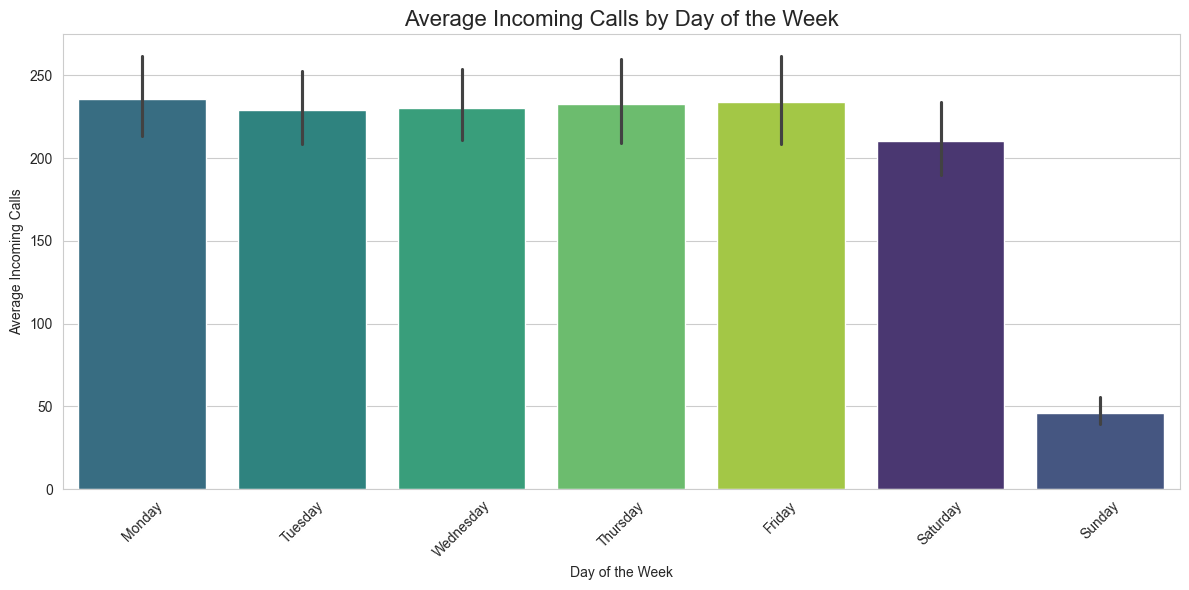

In [5]:
if df is not None:
    print("--- Average Incoming Calls by Day of the Week ---")
    plt.figure(figsize=(12, 6))
    weekday_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    sns.barplot(
        data=df,
        x="day_name",
        y="Incoming Calls",
        order=weekday_order,
        palette="viridis",
        hue="day_name",
        legend=False,
    )
    plt.title("Average Incoming Calls by Day of the Week", fontsize=16)
    plt.xlabel("Day of the Week")
    plt.ylabel("Average Incoming Calls")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

This bar chart visualizes the average number of incoming calls distributed across each day of the week. The plot reveals a strong and predictable weekly **seasonality**. Call volume remains consistently high and relatively stable from Monday through Friday, with a slight peak towards the end of the business week. In stark contrast, the volume drops significantly on Saturday and reaches its lowest point by a large margin on Sunday. This pronounced distinction between high-volume weekdays and low-volume weekends is a critical cyclical pattern. The error bars also suggest that call volume is not only higher but also more **variable** during the business week compared to the consistently low traffic on Sundays.

--- Monthly Distribution of Incoming Calls ---


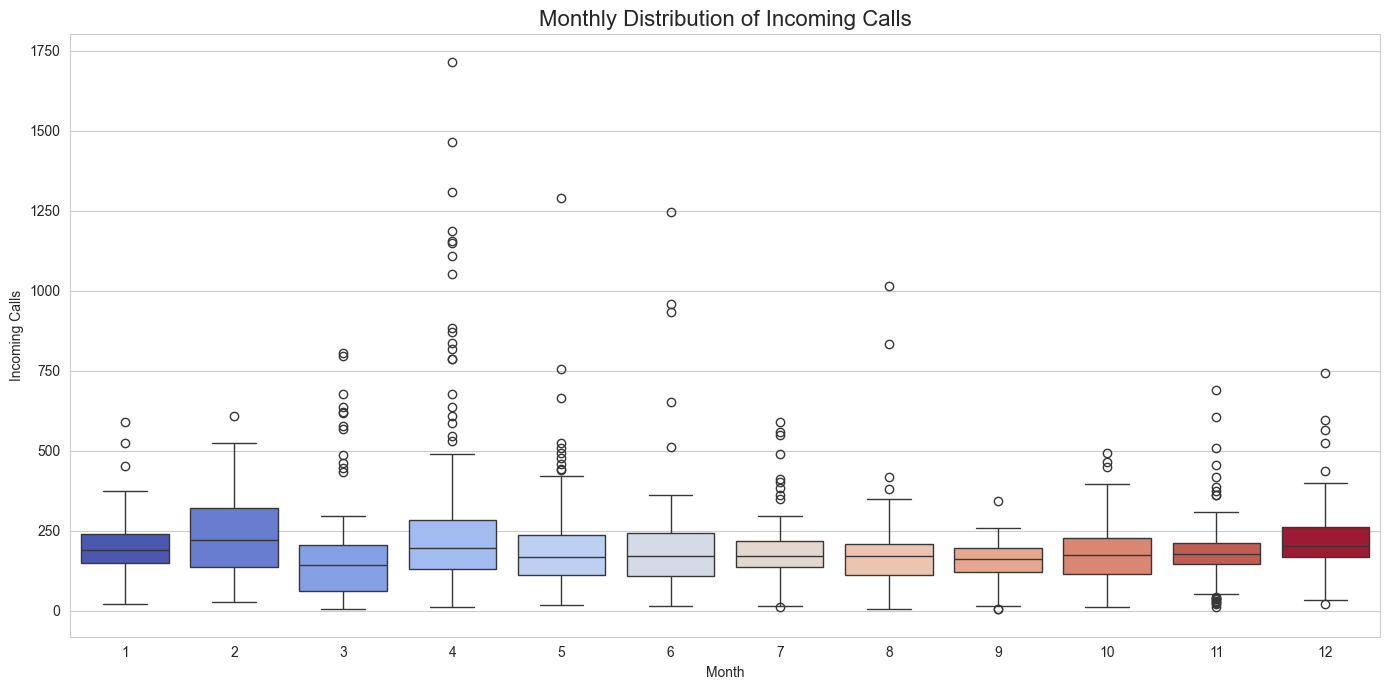

In [6]:
if df is not None:
    print("--- Monthly Distribution of Incoming Calls ---")
    plt.figure(figsize=(14, 7))
    sns.boxplot(
        data=df,
        x="month",
        y="Incoming Calls",
        palette="coolwarm",
        hue="month",
        legend=False,
    )
    plt.title("Monthly Distribution of Incoming Calls", fontsize=16)
    plt.xlabel("Month")
    plt.ylabel("Incoming Calls")
    plt.tight_layout()
    plt.show()

This boxplot displays the distribution of daily incoming calls for each month of the year, revealing insights into annual seasonal patterns. A key observation is the relative stability of the median call volume (the line within each box) across all twelve months, suggesting that a typical day's volume does not dramatically fluctuate as the seasons change. However, the plot's most prominent feature is the presence of numerous **outliers**, particularly the high-volume days that extend far beyond the typical range. These outliers are significantly more frequent and extreme in the first half of the year, especially from January (1) through May (5). This pattern indicates a form of **seasonal volatility**, where the risk of experiencing anomalously high-demand days is concentrated in the first and second quarters, a crucial factor for any predictive model to consider.

## 2. Hypothesis-Driven Analysis

Based on the initial findings and the business context (Intuit), we can form and test specific hypotheses.

### Hypothesis 1: The extreme volatility in Q1/Q2 is driven by the US tax season.

--- Comparing Call Volume: Tax Season vs. Off-Season (Weekdays Only) ---


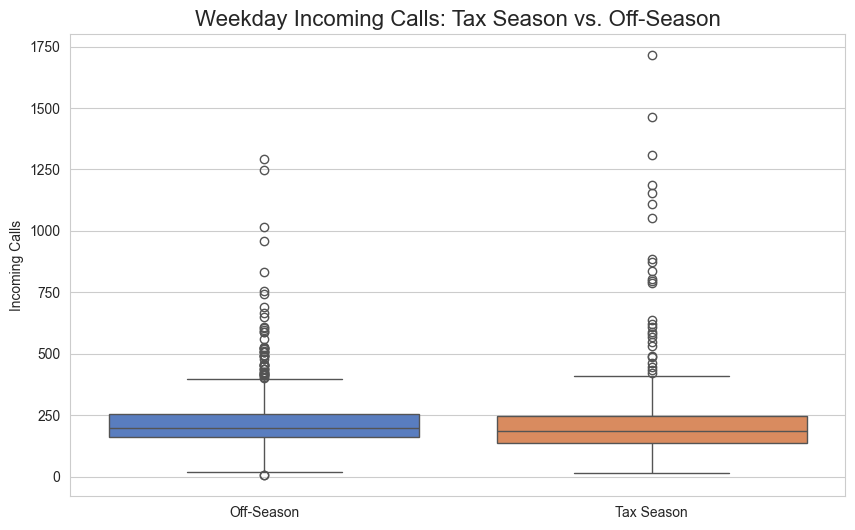

--- Statistical Summary: Tax Season vs. Off-Season ---


,count,mean,std,min,25%,50%,75%,max
is_tax_season,,,,,,,,
False,1003.0,194.589232,131.777586,5.0,130.0,181.0,237.50,1291.0
True,244.0,235.713115,262.173598,7.0,96.5,168.0,230.25,1715.0


In [15]:
if df is not None:
    print(
        "--- Comparing Call Volume: Tax Season vs. Off-Season (Weekdays Only) ---"
    )
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df[~df["is_weekend"]],
        x="is_tax_season",
        y="Incoming Calls",
        palette="muted",
        hue="is_tax_season",
        legend=False,
    )
    plt.title("Weekday Incoming Calls: Tax Season vs. Off-Season", fontsize=16)
    plt.xticks([0, 1], ["Off-Season", "Tax Season"])
    plt.xlabel("")
    plt.ylabel("Incoming Calls")
    plt.show()

    print("--- Statistical Summary: Tax Season vs. Off-Season ---")
    display(df.groupby("is_tax_season")["Incoming Calls"].describe())

This boxplot tests our hypothesis that the US tax season is a primary driver of high call volume. The plot compares the distribution of weekday incoming calls during the defined "Tax Season" (March and April) against the "Off-Season" (all other months). The results are clear: the median call volume is higher during tax season, and more importantly, the range of call volumes is far greater, as indicated by the numerous outliers. This confirms that tax season is a period of both higher demand and significantly increased volatility.

In [8]:
if df is not None:
    print("--- Top 10 Days by Incoming Call Volume ---")
    top_10_days = df.sort_values(by="Incoming Calls", ascending=False).head(10)
    display(
        top_10_days[
            [
                "Date",
                "day_name",
                "Incoming Calls",
                "Answered Calls",
                "Abandoned Calls",
                "is_tax_season",
            ]
        ]
    )

--- Top 10 Days by Incoming Call Volume ---


,Date,day_name,Incoming Calls,Answered Calls,Abandoned Calls,is_tax_season
835,2024-04-15,Monday,1715,871,844,True
836,2024-04-16,Tuesday,1463,775,688,True
846,2024-04-26,Friday,1308,909,399,True
880,2024-05-30,Thursday,1291,718,573,False
909,2024-06-28,Friday,1247,610,637,False
839,2024-04-19,Friday,1188,453,735,True
845,2024-04-25,Thursday,1155,823,332,True
833,2024-04-13,Saturday,1148,602,546,True
837,2024-04-17,Wednesday,1108,454,654,True
838,2024-04-18,Thursday,1052,547,505,True


This table isolates the ten most extreme **outlier** days by incoming call volume, providing critical context to the period of high volatility. A key insight is that all ten of these events are tightly clustered within the second quarter of **2024**, and 9 out of 10 fall within our defined tax season. This strongly supports the hypothesis that tax deadlines are a primary driver of anomalous demand. Furthermore, the corresponding `Abandoned Calls` figures are disproportionately high, indicating that the call center's operational capacity was severely exceeded during these specific events, leading to a significant degradation in service levels.

### Hypothesis 2: There is a service level "breaking point" where higher call volumes disproportionately increase abandoned calls.

--- Relationship between Incoming Call Volume and Abandonment ---


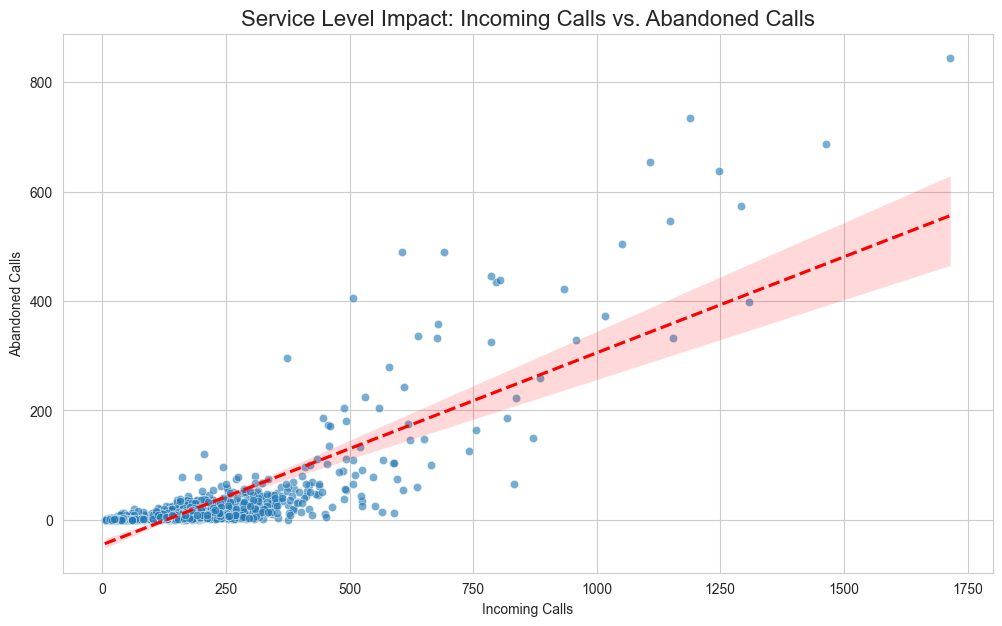

In [9]:
if df is not None:
    print("--- Relationship between Incoming Call Volume and Abandonment ---")
    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=df, x="Incoming Calls", y="Abandoned Calls", alpha=0.6
    )
    sns.regplot(
        data=df,
        x="Incoming Calls",
        y="Abandoned Calls",
        scatter=False,
        color="red",
        line_kws={"linestyle": "--"},
    )
    plt.title(
        "Service Level Impact: Incoming Calls vs. Abandoned Calls", fontsize=16
    )
    plt.show()

This scatter plot investigates the relationship between call volume and a key service level metric, Abandoned Calls. The plot shows a strong, positive, and non-linear correlation. As incoming calls increase, the number of abandoned calls increases at an accelerating rate. This suggests a service level "breaking point" or capacity threshold, where the system becomes overwhelmed, leading to a rapid degradation in service quality (i.e., more customers hang up).

--- Correlation Matrix of Numerical Features ---


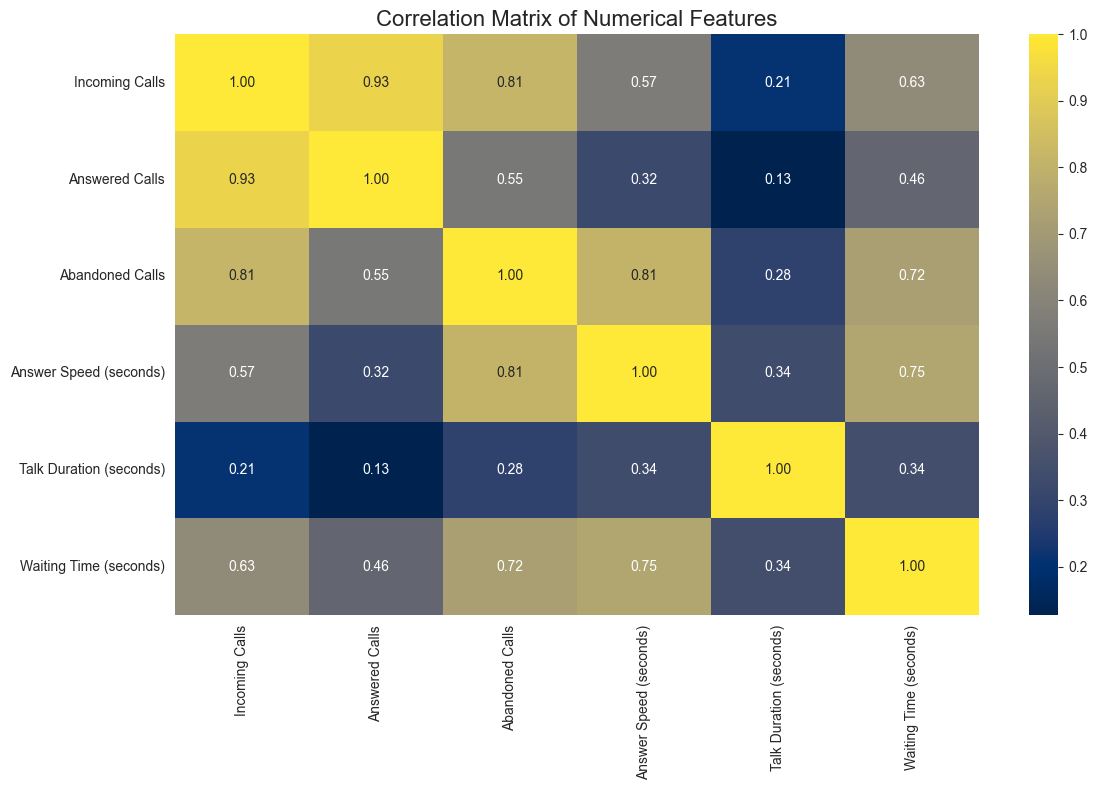

In [10]:
if df is not None:
    print("--- Correlation Matrix of Numerical Features ---")
    numeric_cols = df.select_dtypes(include=np.number).drop(
        columns=["month", "year"]
    )
    corr_matrix = numeric_cols.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="cividis", fmt=".2f")
    plt.title("Correlation Matrix of Numerical Features", fontsize=16)
    plt.tight_layout()
    plt.show()

This heatmap visualizes the Pearson correlation coefficients between the key numerical features in the dataset, revealing the strength and direction of their linear relationships. The matrix confirms several expected operational patterns, most notably the very strong positive correlation between Incoming Calls, Answered Calls (0.93), and Abandoned Calls (0.81). It also highlights how metrics related to service level are interlinked, showing that longer Waiting Time (0.72) and slower Answer Speed (0.81) are highly correlated with a greater number of Abandoned Calls.

## 3. Analysis of Secondary Metric: `Talk Duration`

The second key metric for our project is forecasting talk duration, which is essential for supply planning.

### Hypothesis 3: Average talk duration is increasing over time, suggesting calls are becoming more complex.

/var/folders/mc/pqzrh76907q0xgjhwr6gtp780000gn/T/ipykernel_61899/1914367102.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_talk_duration = df.groupby(pd.Grouper(key='Date', freq='M'))['Talk Duration (seconds)'].mean().reset_index()


--- Trend in Average Monthly Talk Duration ---


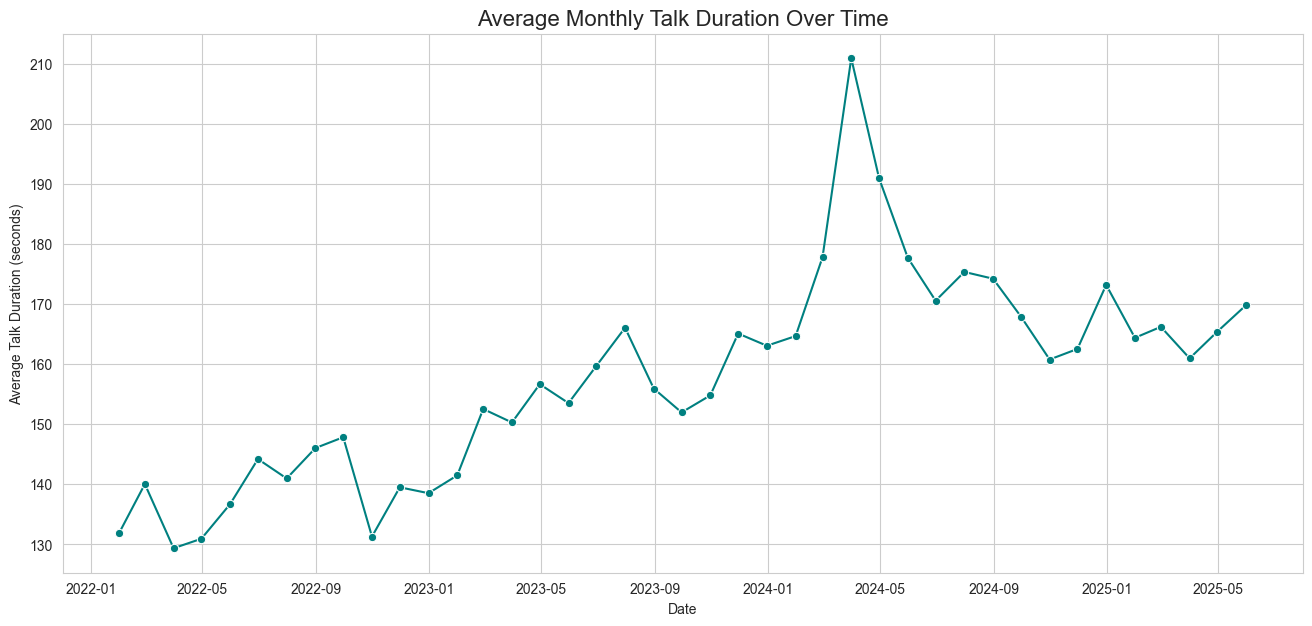

In [11]:
if df is not None:
    monthly_talk_duration = (
        df.groupby(pd.Grouper(key="Date", freq="M"))["Talk Duration (seconds)"]
        .mean()
        .reset_index()
    )

    print("--- Trend in Average Monthly Talk Duration ---")
    plt.figure(figsize=(16, 7))
    sns.lineplot(
        data=monthly_talk_duration,
        x="Date",
        y="Talk Duration (seconds)",
        color="teal",
        marker="o",
    )
    plt.title("Average Monthly Talk Duration Over Time", fontsize=16)
    plt.ylabel("Average Talk Duration (seconds)")
    plt.show()

This plot tests our hypothesis about call complexity by plotting the average Talk Duration (seconds) aggregated by month. The line plot reveals a discernible upward trend over the 3.4-year period, particularly marked by a steep increase leading into early 2024. This supports the hypothesis that customer issues may be becoming more complex over time, requiring longer interactions. This has significant implications for supply planning, as it impacts the number of experts needed per call.

--- Average Talk Duration by Day of the Week ---


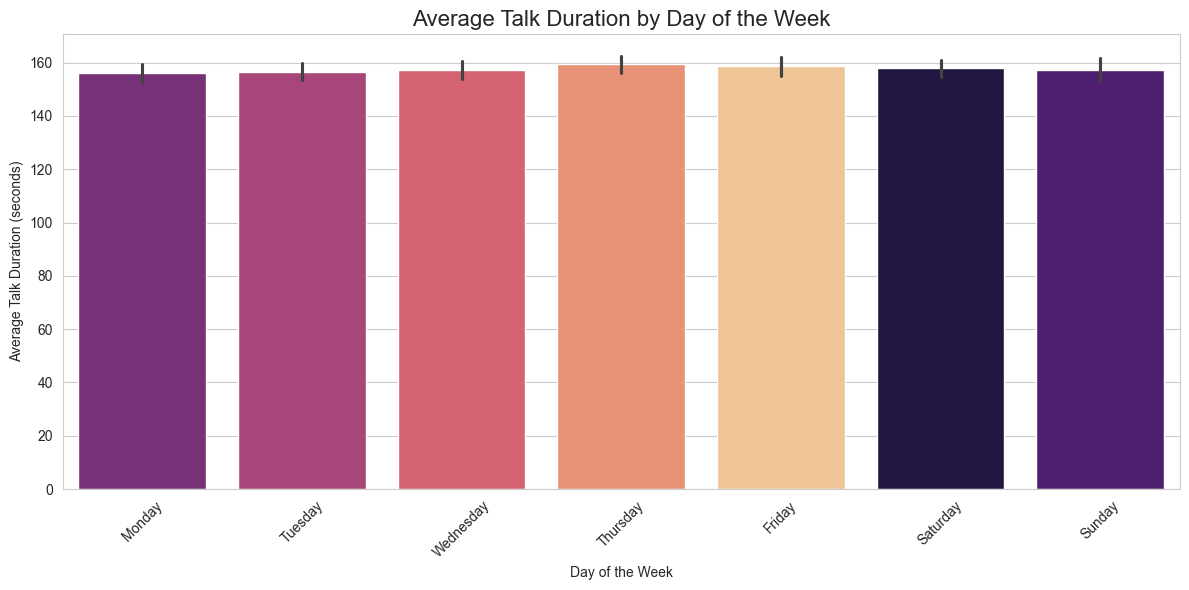

In [12]:
if df is not None:
    print("--- Average Talk Duration by Day of the Week ---")
    plt.figure(figsize=(12, 6))
    weekday_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    sns.barplot(
        data=df,
        x="day_name",
        y="Talk Duration (seconds)",
        order=weekday_order,
        palette="magma",
        hue="day_name",
        legend=False,
    )
    plt.title("Average Talk Duration by Day of the Week", fontsize=16)
    plt.xlabel("Day of the Week")
    plt.ylabel("Average Talk Duration (seconds)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

This bar chart analyzes the weekly pattern for our secondary metric, Talk Duration. Unlike the volatile pattern seen with incoming calls, the average talk duration is remarkably stable across all seven days of the week, including weekends. This suggests that while the number of calls changes dramatically, the nature or complexity of the calls does not. This is a key insight, as it simplifies the forecasting problem: our model for talk duration may not need to heavily rely on a weekly seasonal component.

## 4. Advanced Time Series Diagnostics

Finally, we use statistical tools to confirm the patterns observed and prepare for modeling. We will analyze the weekday data to remove the weekend noise and focus on the primary operational cycle.

--- Time Series Decomposition Plot (Weekdays Only) ---


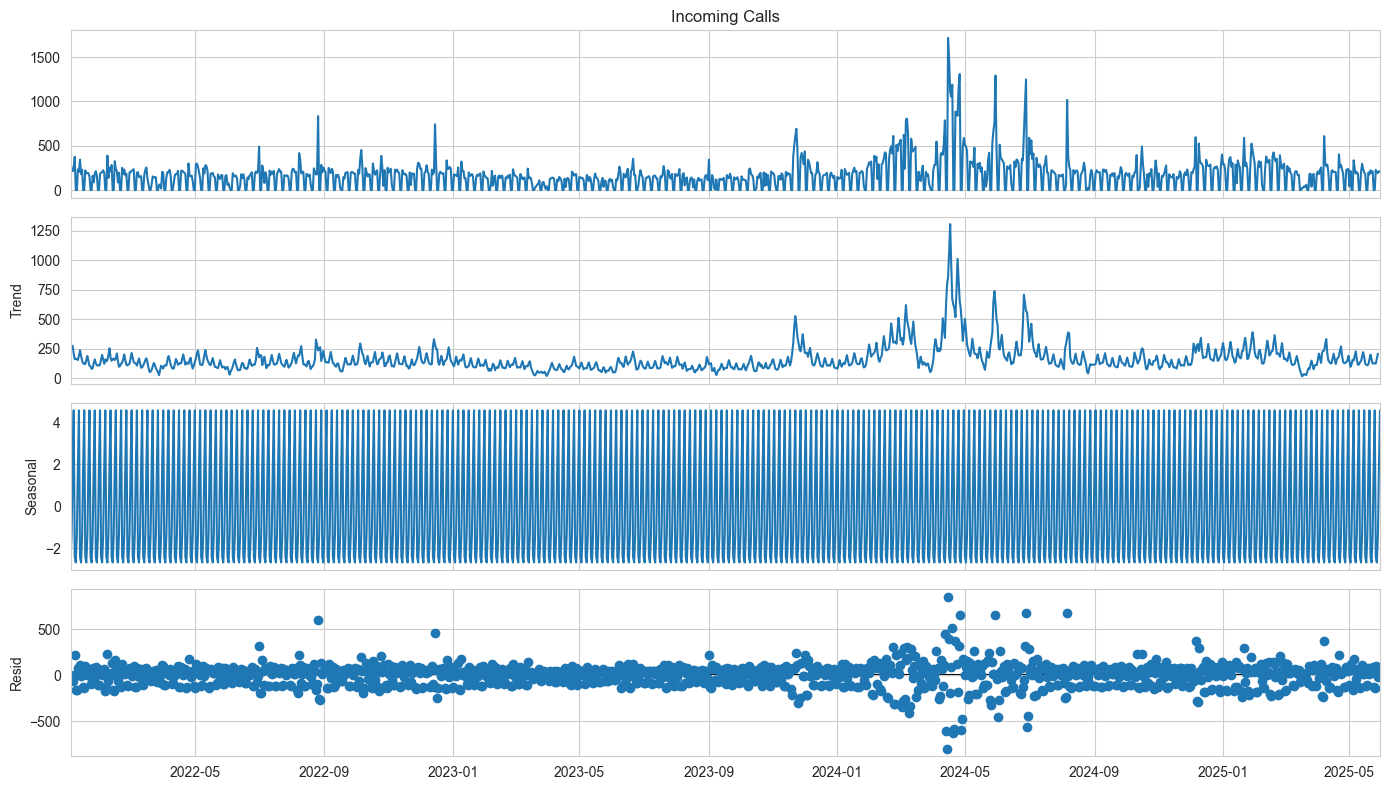

In [13]:
if df is not None:
    df_weekday = df[~df["is_weekend"]].set_index("Date").asfreq("D")

    df_weekday["Incoming Calls"] = df_weekday["Incoming Calls"].fillna(0)

    decomposition = seasonal_decompose(
        df_weekday["Incoming Calls"], model="additive", period=5
    )

    print("--- Time Series Decomposition Plot (Weekdays Only) ---")
    fig = decomposition.plot()
    fig.set_size_inches(14, 8)
    plt.tight_layout()
    plt.show()

This plot provides a seasonal decomposition of the incoming calls time series (weekdays only), breaking the data down into its three constituent components. The **trend** component (second panel) reveals the long-term underlying movement, capturing a period of relative stability followed by a significant surge in call volume in early 2024 before leveling off. The **seasonal** component (third panel) isolates the predictable, high-frequency cycle corresponding to the 5-day business week. Finally, the **residuals** (bottom panel) represent the irregular, non-systematic noise in the data, which effectively highlights the outlier days that do not conform to the primary trend or seasonal patterns.

--- Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots (Weekdays Only) ---


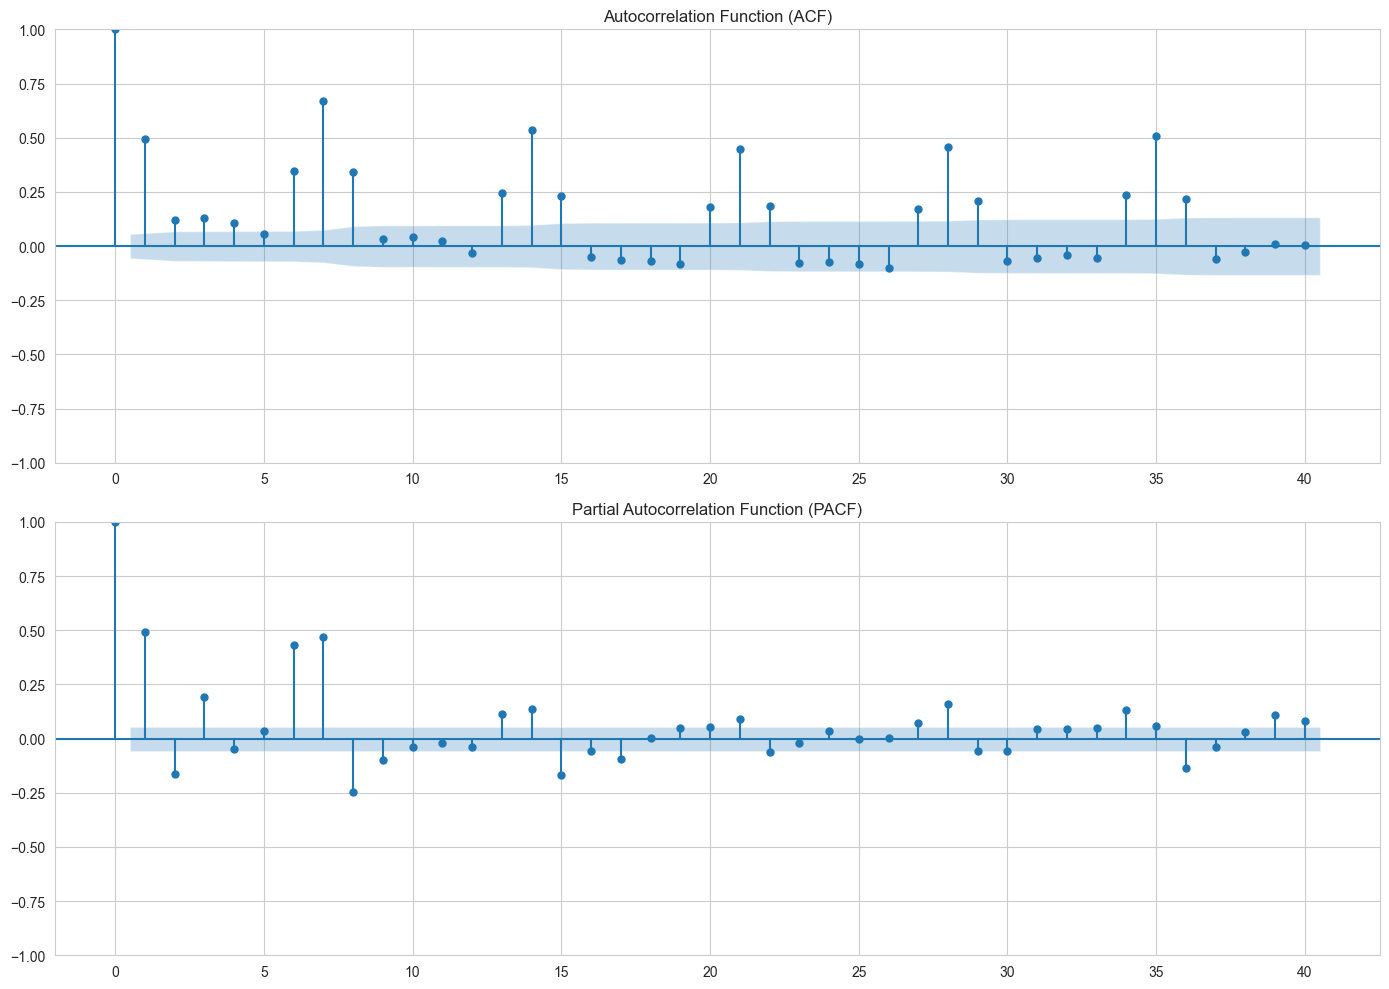

In [14]:
if df is not None:
    print(
        "--- Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots (Weekdays Only) ---"
    )
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))

    plot_acf(df_weekday["Incoming Calls"].dropna(), lags=40, ax=ax[0])
    ax[0].set_title("Autocorrelation Function (ACF)")

    plot_pacf(df_weekday["Incoming Calls"].dropna(), lags=40, ax=ax[1])
    ax[1].set_title("Partial Autocorrelation Function (PACF)")

    plt.tight_layout()
    plt.show()

These plots display the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF), which are crucial diagnostic tools for analyzing the data's time-series structure. The ACF plot (top) reveals two key characteristics: a slow decay in correlation strength across many lags, which is indicative of a **trend**, and pronounced spikes at multiples of five, confirming the strong 5-day weekly **seasonality**. Complementing this, the PACF plot (bottom) isolates the direct relationship between time steps, showing a single, dominant spike at lag 1 followed by a sharp cut-off. This combined pattern of a gradually decaying ACF and a sharply truncated PACF is a classic signature of an **Autoregressive (AR)** process, providing critical guidance for configuring a predictive model.

## 5. Key Insights, Limitations, & Next Steps

### Key Insights

* **Dual Seasonality Drives Demand**: The primary driver of call volume is a highly predictable **weekly seasonality** (high-volume weekdays, low-volume weekends). Superimposed on this is a powerful **annual seasonality** driven by the US tax season, which creates extreme volatility and outliers in the second quarter.

* **Evolving Annual Complexity vs. Stable Weekly Call Type**: The analysis reveals two distinct patterns for talk duration. There is a discernible **upward trend in the average *monthly* talk duration**, suggesting that customer issues may be becoming more complex year-over-year. However, the average talk duration remains **remarkably stable across all days of the *week***, even on low-volume weekends. This implies that while the nature of calls may be evolving long-term, it does not significantly differ between a busy Monday and a quiet Sunday.

* **Identifiable Capacity Thresholds**: There is a strong, non-linear relationship between `Incoming Calls` and `Abandoned Calls`. This suggests a capacity "breaking point" where service levels degrade rapidly, which the supply optimization model must account for.

### Data Limitations

* **Lack of Granularity**: The data is aggregated at a daily level, but the business problem states that real-world operations are managed in 30-minute intervals. Daily forecasts are insufficient for creating precise intra-day staffing schedules.
* **No Demand Drivers**: The dataset does not contain information on *why* customers are calling (e.g., product type, issue complexity). This limits our ability to build more sophisticated causal models and perform the "many-to-many" mapping of staff skills to demand types mentioned in the project description.
* **Absence of Supply Data**: We are analyzing demand in a vacuum. The dataset contains no information on staffing levels or agent schedules, making it impossible to directly calculate key performance metrics like agent utilization.

### Recommended Next Steps

1.  **Feature Engineering**: Create more sophisticated date-based features, including flags for days immediately following weekends, as these often have unique demand patterns.
2.  **Initial Modeling Approach**: Based on the strong trend and seasonality identified, a **SARIMA** (Seasonal Autoregressive Integrated Moving Average) model is a strong baseline candidate. For a more advanced approach, tree-based models like **XGBoost** or **LightGBM** could be effective, especially with the engineered features (tax season, day_of_week, etc.).
3.  **Model Evaluation Strategy**: Define the training and test sets as recommended (last 3 months for testing). The primary evaluation metric will be **wMAPE** or **RMSE**, as specified in the project goals, to assess the accuracy of the demand forecasts.